In [310]:
import tifffile as tiff
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
import SimpleITK as sitk
from skimage.filters import threshold_otsu
from scipy.ndimage import minimum_filter, label

In [311]:
folder_xct = Path(r'E:\temporal\volumenes\32+33+34+35\33')

filename_xct = folder_xct / 'frontal_cropped.tif'

output_folder = folder_xct / 'output'

output_folder.mkdir(exist_ok=True)

xct = tiff.imread(filename_xct)
xct = np.swapaxes(xct, 0, 1)
xct = np.swapaxes(xct, 1, 2)

print(xct.shape)

folder_ut = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\03_UT_data\Panel PEGASO\Pruebas Pegatinas\doble cara 5\33')

filename_ut = folder_ut / 'aligned.tif'

output_folder.mkdir(exist_ok=True)

ut = tiff.imread(filename_ut)
ut = np.swapaxes(ut, 0, 1)
ut = np.swapaxes(ut, 1, 2)

print(ut.shape)

(3282, 1900, 300)
(146, 60, 506)


In [312]:

def resize_image(original_image, size, show = False):
    width, height = original_image.size
    if show:
        print(f"The original image size is {width} wide x {height} tall")

    resized_image = original_image.resize(size)
    width, height = resized_image.size
    if show:
        print(f"The resized image size is {width} wide x {height} tall")
    return np.array(resized_image)

def calculate_new_dimensions(original_resolution, new_resolution, original_dimensions):
    # Calculate the original dimensions in real-world units
    original_width, original_height = original_dimensions
    real_world_width = original_width * original_resolution
    real_world_height = original_height * original_resolution

    # Calculate the new dimensions in pixels
    new_width = int(real_world_width / new_resolution)
    new_height = int(real_world_height / new_resolution)

    return new_width, new_height

def get_brightest(d):
    data = d.copy()
    #turn to 0 the values below 255
    data[data < 255] = 0
    #calculate the max of each image
    max_values = np.sum(data, axis=(0, 1))
    
    return np.argmax(max_values)

def paste_image_center(img1_array, img2_array):
    # Convert numpy arrays to PIL Images
    img1 = Image.fromarray(img1_array)
    img2 = Image.fromarray(img2_array)

    # Create a new image of zeros with the same shape as img1
    new_img = Image.fromarray(np.zeros_like(img1_array))

    # Calculate the position for the second image
    position = ((new_img.size[0]-img2.size[0])//2, (new_img.size[1]-img2.size[1])//2)

    # Paste the second image onto the new image
    new_img.paste(img2, position)

    # Convert back to numpy array and return
    return np.array(new_img)

def label_objects(image):
    labeled_image, num_features = label(image)
    output_image = np.zeros_like(image)
    
    indices = np.where(labeled_image > 0)
    indices = list(zip(indices[0], indices[1]))
    
    # Label the object nearest to the top edge
    top_object = min(indices, key=lambda x: x[0])
    output_image[top_object] = 100
    indices.remove(top_object)
    
    if indices:
        # Label the object nearest to the left edge
        left_object = min(indices, key=lambda x: x[1])
        output_image[left_object] = 175
        indices.remove(left_object)
    
    # Label the remaining objects
    for idx in indices:
        output_image[idx] = 255
    
    return output_image

In [313]:
def plot_images(images, figsz = (5, 5)):
    fig, axs = plt.subplots(1, len(images), figsize=figsz)
    for i, img in enumerate(images):
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
    plt.show()

def circles(img):
    # Convert binary image to grayscale
    img = (img * 255).astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image to draw circles on
    circle_img = np.zeros_like(img)

    # For each contour
    for contour in contours:
        # Find minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(contour)
        # Draw the circle
        cv2.circle(circle_img, (int(x), int(y)), int(radius), (255, 255, 255), -1)

        break

    return circle_img

def rectangles(img, thickness=2):
    # Convert binary image to grayscale
    img = (img * 255).astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image to draw rectangles on
    rectangle_img = np.zeros_like(img)

    # For each contour
    for contour in contours:
        # Find bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        # Draw the rectangle contour
        cv2.rectangle(rectangle_img, (x, y), (x+w, y+h), (255, 255, 255), thickness)

    return rectangle_img > 0

import cv2
import numpy as np

def draw_bounding_box(image):

    # Convert binary image to grayscale
    image = (image * 255).astype(np.uint8)

    # Create a new binary image of the same size
    output_image = np.zeros_like(image)

    # Find contours in the image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, draw the bounding box on the new image
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(output_image, (x, y), (x+w, y+h), (255), -1)

    return output_image > 0

def find_rectangle_centers(image):
    # Ensure the image is binary
    assert np.array_equal(image, image.astype(bool)), "Image must be binary"

    # Find connected components in the image
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image.astype('uint8'))

    # The first component is the background, so ignore it
    return centroids[1:]

def paint_points_on_image(points, image):
    # Create a copy of the image to avoid modifying the original
    image_copy = np.copy(image)

    # Convert the image to RGB if it's grayscale
    if len(image_copy.shape) == 2:
        image_copy = np.stack((image_copy,)*3, axis=-1)

    # Paint each point in red
    for point in points:
        x, y = point
        image_copy[int(y), int(x)] = [255, 0, 0]  # RGB for red

    return image_copy

def find_local_minima(image, size=3, threshold=50):
    # Apply the minimum filter
    filtered_image = minimum_filter(image, size)

    # Find local minima
    local_minima = image == filtered_image

    # Apply threshold
    local_minima = np.logical_and(local_minima, image <= threshold)

    # The result is a boolean mask where True indicates local minima
    return local_minima

def find_brightest_ut(volume):
    # Find the brightest slice
    brightest_slice = np.argmax(np.sum(volume, axis=(0, 1)))

    return brightest_slice

def paint_binary_points(shape, points):
    # Create an empty image of the specified shape
    image = np.zeros(shape, dtype=np.uint8)

    # Iterate over the points
    for point in points:
        # Round the coordinates to the nearest integer
        y,x = tuple(int(round(coord)) for coord in point)
        # cv2.circle(image, (y,x), 5, (255), -1)
        # Draw the point on the image
        image[x,y] = 255

    return image.astype(np.uint8)

In [314]:
aligned_point = find_brightest_ut(ut)
original_resolution = 0.022
new_resolution = 1
print(aligned_point)
gate1 = (aligned_point, aligned_point+1)

145


The new dimensions are (72, 41)
(72, 41, 300)
140


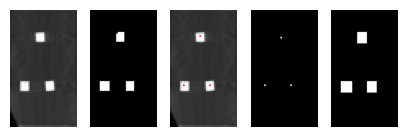

In [315]:

id = get_brightest(xct)

original_dimensions = (xct.shape[0], xct.shape[1])
new_dimensions = calculate_new_dimensions(original_resolution, new_resolution, original_dimensions)
print(f"The new dimensions are {new_dimensions}")
resized = resize_image(Image.fromarray(xct[:,:,id]), new_dimensions[::-1])

#resized the whole volume
resized_xct = np.zeros((new_dimensions[0], new_dimensions[1], xct.shape[2]), dtype=np.uint8)
for i in range(xct.shape[2]):
    resized_xct[:,:,i] = resize_image(Image.fromarray(xct[:,:,i]), new_dimensions[::-1])

print(resized_xct.shape)

thresh = threshold_otsu(resized)

print(thresh)

thresholded = resized > thresh

xct_centers  = find_rectangle_centers(thresholded)

centers_painted_xct = paint_binary_points(thresholded.shape, xct_centers)

xct_mask = draw_bounding_box(thresholded) * 1

plot_images([resized, thresholded, paint_points_on_image(xct_centers, resized), centers_painted_xct, xct_mask])

43


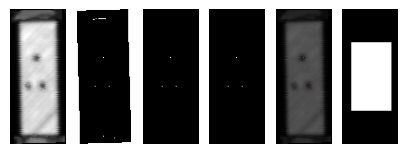

In [316]:
#get the gates
gated_data = ut[:,:,gate1[0]:gate1[1]].reshape(ut.shape[0], ut.shape[1])

#otsu threshold
thresh = threshold_otsu(gated_data)

#create a mask
thresholded = gated_data > thresh

thresholded = ndimage.binary_fill_holes(thresholded)

print(thresh)

minimums = find_local_minima(gated_data, 10)

only_minimus = minimums * thresholded

centers = find_rectangle_centers(only_minimus)

centers_painted_ut = paint_binary_points(gated_data.shape, centers)

ut_mask = draw_bounding_box(thresholded) * 1

# Assuming 'arr' is your numpy array
rows, cols = ut_mask.shape

# Calculate quarter of the rows
quarter_rows = rows // 4

# Set first and last quarter rows to 0
ut_mask[:quarter_rows, :] = 0
ut_mask[-quarter_rows:, :] = 0

#paint the centers in the max projection
max_projection_centers = paint_points_on_image(centers, gated_data)

plot_images([gated_data, minimums, only_minimus, centers_painted_ut, max_projection_centers, ut_mask])

(146, 60)
(72, 41)
(146, 60)


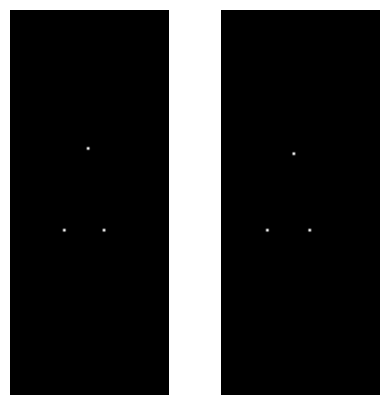

In [317]:
centers_painted_xct_big = paste_image_center(centers_painted_ut, centers_painted_xct)

print(centers_painted_ut.shape)

print(centers_painted_xct.shape)

print(centers_painted_xct_big.shape)

plot_images([centers_painted_ut, centers_painted_xct_big])

In [318]:
labeled_ut = label_objects(centers_painted_ut)
labeled_xct = label_objects(centers_painted_xct)

#save bot as tiff
tiff.imsave(output_folder / 'labeled_ut.tif', labeled_ut)
tiff.imsave(output_folder / 'labeled_xct.tif', labeled_xct)

C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_3604\3028719024.py:5: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_folder / 'labeled_ut.tif', labeled_ut)
C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_3604\3028719024.py:6: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_folder / 'labeled_xct.tif', labeled_xct)


In [319]:
fixed_image = sitk.GetImageFromArray(labeled_ut)
moving_image = sitk.GetImageFromArray(labeled_xct)
fixed_mask = sitk.GetImageFromArray(ut_mask)
moving_mask = sitk.GetImageFromArray(xct_mask)

# Initial alignment of the two volumes
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                    moving_image, 
                                                    sitk.Euler2DTransform(), 
                                                    sitk.CenteredTransformInitializerFilter.GEOMETRY)

# Set up the registration framework
registration_method = sitk.ImageRegistrationMethod()
#registration_method.SetMetricFixedMask(fixed_mask)
#registration_method.SetMetricMovingMask(moving_mask)

# Similarity metric settings
registration_method.SetMetricAsMattesMutualInformation()

# Interpolator
# registration_method.SetInterpolator(sitk.sitkLinear)

# # Optimizer settings
# registration_method.SetOptimizerAsRegularStepGradientDescent(
#     learningRate=1.0, 
#     minStep=1e-6,  # Decreased from 1e-5 to 1e-6
#     numberOfIterations=1000,  # Increased from 5000 to 10000
#     relaxationFactor=0.5, 
#     gradientMagnitudeTolerance=1e-9,  # Decreased from 1e-8 to 1e-9
#     estimateLearningRate=registration_method.EachIteration
# )
# registration_method.SetOptimizerScalesFromPhysicalShift()

# Optimizer settings
registration_method.SetOptimizerAsExhaustive(numberOfSteps=[5,5,5], stepLength = 1.0)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times
registration_method.SetInitialTransform(initial_transform, inPlace=False)


In [320]:

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                            sitk.Cast(moving_image, sitk.sitkFloat32))

In [321]:
print("Final transformation parameters: \n", final_transform.GetParameters())
# Get the original parameters
original_parameters = np.array(final_transform.GetParameters())

# Compute the scaling factor
scaling_factor = 1 / 0.22

# Adjust the translation parameters
adjusted_parameters = original_parameters.copy()
adjusted_parameters[1:] *= scaling_factor

# Create a new transform of the same type
new_transform = sitk.Euler3DTransform()
transform_3d = sitk.Euler3DTransform()


# Create a new set of parameters for the 3D transform
# Set the rotation parameters to the same as the 2D transform
# Set the translation parameters to the same as the 2D transform for x and y, and 0 for z
params_3d = (adjusted_parameters[0], 0, 0, adjusted_parameters[1], adjusted_parameters[2], 0)
params_3d2 = (original_parameters[0], 0, 0, original_parameters[1], original_parameters[2], 0)

# Set the parameters of the 3D transform
new_transform.SetParameters(params_3d)
transform_3d.SetParameters(params_3d2) 

print("New 3D transformation parameters: \n", new_transform.GetParameters())


Final transformation parameters: 
 (0.0, -11.5, -37.0)
New 3D transformation parameters: 
 (0.0, 0.0, 0.0, -52.27272727272728, -168.1818181818182, 0.0)


In [322]:
# Now, apply the transform to the top volume overlaping reggion
resampler = sitk.ResampleImageFilter()
resampler.SetTransform(final_transform)
resampler.SetDefaultPixelValue(0) 

# Set the properties of the resampler to match the original top volume
resampler.SetOutputSpacing(fixed_image.GetSpacing())
resampler.SetSize(fixed_image.GetSize())
resampler.SetOutputDirection(fixed_image.GetDirection())
resampler.SetOutputOrigin(fixed_image.GetOrigin())

# Apply the transformation
registered = resampler.Execute(moving_image)

resized_registered = resampler.Execute(sitk.GetImageFromArray(resized))

#resized the whole volume
registered_volume = np.zeros((resized_xct.shape[2],centers_painted_ut.shape[0], centers_painted_ut.shape[1]), dtype=np.uint8)
print(registered_volume.shape)
for i, img in enumerate(resized_xct):
    a = resampler.Execute(sitk.GetImageFromArray(resized_xct[i]))
    a = sitk.GetArrayFromImage(a)
    registered_volume[i] = a

(300, 146, 60)


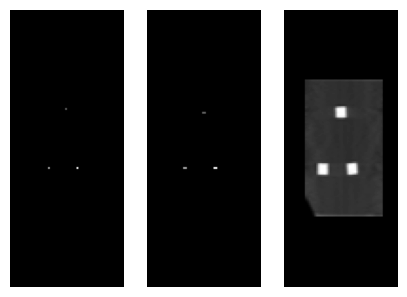

In [323]:
plot_images([sitk.GetArrayFromImage(fixed_image),sitk.GetArrayFromImage(registered),sitk.GetArrayFromImage(resized_registered)])

In [324]:
#create a npzeros array with the same shape as the ut volume converted to the new resolution
new_shape = calculate_new_dimensions(1, 0.022, (ut.shape[0], ut.shape[1]))

big_ut = np.zeros((xct.shape[2],new_shape[0], new_shape[1]), dtype=np.uint8)

big_ut_itk = sitk.GetImageFromArray(big_ut)
big_ut_itk.SetSpacing((original_resolution, original_resolution,original_resolution))

print(big_ut.shape)

(300, 6636, 2727)


In [325]:
xct = np.swapaxes(xct, 2, 1)
xct = np.swapaxes(xct, 1, 0)
print(xct.shape)

(300, 3282, 1900)


In [326]:
xct_itk = sitk.GetImageFromArray(xct)
xct_itk.SetSpacing((original_resolution, original_resolution,original_resolution))

In [327]:
print(xct_itk.GetSize())
print(big_ut_itk.GetSize())

(1900, 3282, 300)
(2727, 6636, 300)


In [328]:
resampler = sitk.ResampleImageFilter()
resampler.SetTransform(transform_3d)

resampler.SetOutputSpacing(big_ut_itk.GetSpacing())
resampler.SetOutputOrigin(big_ut_itk.GetOrigin())
resampler.SetOutputDirection(big_ut_itk.GetDirection())
resampler.SetSize(big_ut_itk.GetSize())

resampled_xct = resampler.Execute(xct_itk)

resampled_xct = sitk.GetArrayFromImage(resampled_xct).astype(np.uint8)

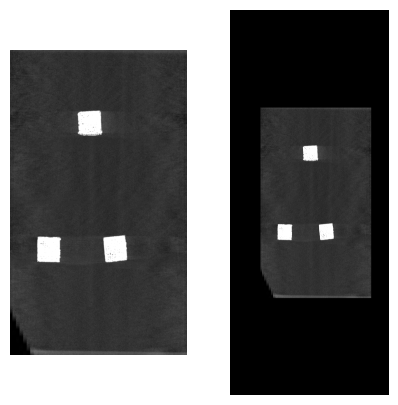

In [329]:
plot_images([xct[id], resampled_xct[id]])

In [330]:
#save the resampled xct
tiff.imwrite(output_folder / 'resampled_xct.tif', resampled_xct[id])

In [331]:
#save the fixed image
tiff.imsave(output_folder / 'fixed.tif', sitk.GetArrayFromImage(fixed_image))
#save the registered image
tiff.imsave(output_folder / 'registered.tif', sitk.GetArrayFromImage(registered))
#save the resized registered image
tiff.imsave(output_folder / 'resized_registered.tif', sitk.GetArrayFromImage(resized_registered))
#save the registered volume
tiff.imsave(output_folder / 'registered_volume.tif', registered_volume)
# #save the resampled xct
# tiff.imsave(output_folder / 'resampled_xct.tif', resampled_xct)
#save centers xct
tiff.imsave(output_folder / 'centers_xct.tif', centers_painted_xct)

C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_3604\2280146284.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_folder / 'fixed.tif', sitk.GetArrayFromImage(fixed_image))
C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_3604\2280146284.py:4: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_folder / 'registered.tif', sitk.GetArrayFromImage(registered))
C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_3604\2280146284.py:6: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_folder / 'resized_registered.tif', sitk.GetArrayFromImage(resized_registered))
C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_3604\2280146284.py:8: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_folder / 'registered_volume.tif', registered_volume)
C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_3604\228

Mañana tienes que leer lo del correo de Fede.
Despues probar la robustez de los cuadrados.
Despues hacer lo de el punto medio en vez del local minima porque pinta que eso no va a funcionar